## Importing Libraries

In [10]:
!pip3 install pandas
!pip3 install regex
!pip3 install contractions
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install numpy
!pip3 install gensim

In [11]:
!pip install contractions

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import regex as re
import contractions
# stopwords = ENGLISH_STOP_WORDS
# import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# plt.xticks(rotation=70)
# pd.options.mode.chained_assignment = None
# pd.set_option('display.max_colwidth', 100)
# %matplotlib inline

## Loading the Dataset

In [13]:

# Specify the path to your JSON file
file_path = 'complaints-2021-05-14_08_16_.json'

# Open the JSON file
with open(file_path, 'r') as file:
    # Load the JSON data
    data = json.load(file)

# Convert the JSON data to a pandas DataFrame
df = pd.DataFrame(data)

# Now you can work with the DataFrame
# For example, you can access a specific field

In [14]:
data_ = pd.read_json('complaints-2021-05-14_08_16_.json')
dfs: pd.DataFrame = data_["_source"].apply(pd.Series)

In [15]:
dfs.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [16]:
selected_columns = ['complaint_id', 'issue', 'date_received', 'product', 'company_response', 'company', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']

# Create a new DataFrame with only the selected columns
dfs= dfs[selected_columns]

# View the first few rows of the new DataFrame
dfs.head()

,complaint_id,issue,date_received,product,company_response,company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Conventional home mortgage,Yes,,None,Consent not provided
4,3203545,Fees or interest,2019-04-05T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Sanity Checks

In [17]:
dfs.shape

(78313, 11)

In [18]:
dfs.isnull().sum()

complaint_id                     0
issue                            0
date_received                    0
product                          0
company_response                 0
company                          0
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [19]:
null_values = dfs['product'].isnull().sum()

# Print the number of null values
print("Number of null values in the 'product' column:", null_values)

Number of null values in the 'product' column: 0


In [20]:
dfs['complaint_what_happened'].nunique()

20931

In [21]:
filtered_df = dfs[dfs['complaint_what_happened'] != '']

filtered_df

,complaint_id,issue,date_received,product,company_response,company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,3224980,Managing an account,2019-04-27T12:00:00-05:00,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...
78303,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
78309,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


### Example of our Feature and Target VAriable

In [22]:
print('Complaint:', filtered_df['complaint_what_happened'][14])
print('\nProduct category for complaint:',filtered_df['product'][14])

Complaint: my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time  date happen XX/XX/2018 check number XXXX claim number is XXXX with chase

Product category for complaint: Checking or savings account


## Distrbution of our Target Variable

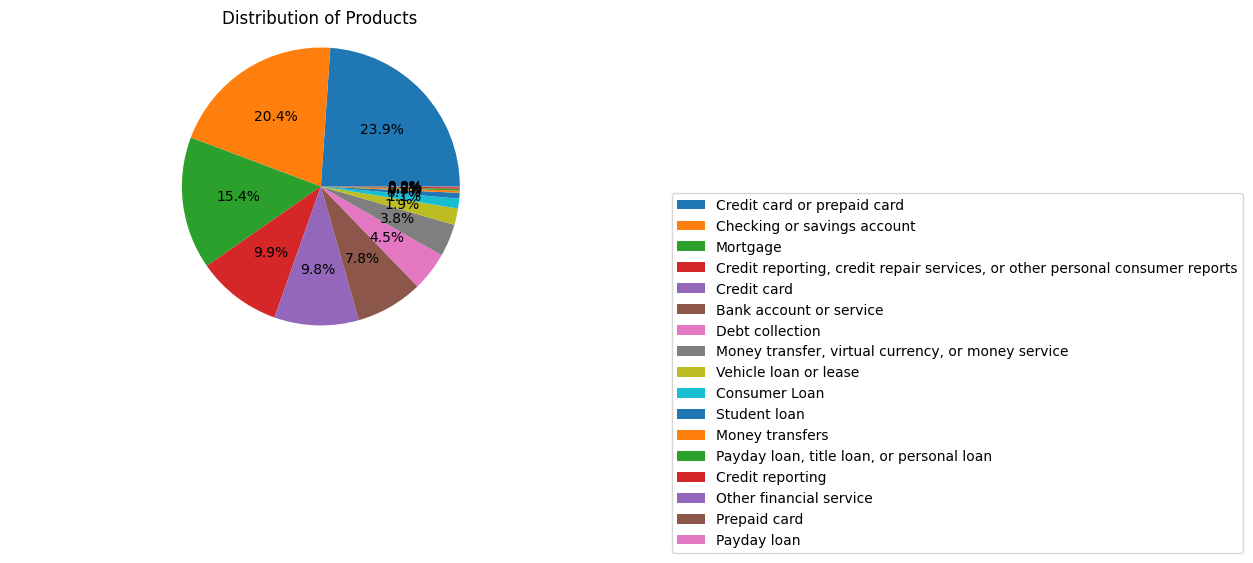

In [23]:

product_counts = filtered_df['product'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 4))
plt.pie(product_counts, labels=None, autopct='%1.1f%%')
plt.title('Distribution of Products')
plt.axis('equal')

# Create a legend for the pie chart
plt.legend(labels=product_counts.index, loc='upper right', bbox_to_anchor=(2, 0.5))

plt.show()

## Pre-Processing our Complaints text feature

In [24]:
rws = filtered_df.loc[:, ['product', 'complaint_what_happened']]

In [25]:
rws

,product,complaint_what_happened
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX..."
14,Checking or savings account,my grand son give me check for {$1600.00} i de...
...,...,...
78303,Credit card or prepaid card,After being a Chase Card customer for well ove...
78309,Credit card or prepaid card,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,Checking or savings account,I am not familiar with XXXX pay and did not un...
78311,Credit card or prepaid card,I have had flawless credit for 30 yrs. I've ha...


## Tokenizing Data

We'll use tokenizer library in order to split each individual word into a token. We will apply NLTK.word_tokenize() function to the “complaint_what_happened” column and create a new column named “tokenized”.

In [26]:
rws['tokenized'] = rws['complaint_what_happened'].apply(word_tokenize)
rws.head()

,product,complaint_what_happened,tokenized
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...,"[Good, morning, my, name, is, XXXX, XXXX, and,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/..."
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,"[Chase, Card, was, reported, on, XX/XX/2019, ...."
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...","[On, XX/XX/2018, ,, while, trying, to, book, a..."
14,Checking or savings account,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, {, $, 1..."


## Converting all Characters to Lowercase
Transforming all words to lowercase is an important pre-processing step. In this case, we will once again append a new column named “lower” to the sliced dataframe which will transform all the tokenized words into lowercase. However, because we have to iterate over multiple words we will use a simple for-loop within a lambda function to apply the “lower” function to each word.

In [27]:
rws['lower'] = rws['tokenized'].apply(lambda x: [word.lower() for word in x])
rws.head()

,product,complaint_what_happened,tokenized,lower
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...,"[Good, morning, my, name, is, XXXX, XXXX, and,...","[good, morning, my, name, is, xxxx, xxxx, and,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/..."
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,"[Chase, Card, was, reported, on, XX/XX/2019, ....","[chase, card, was, reported, on, xx/xx/2019, ...."
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...","[On, XX/XX/2018, ,, while, trying, to, book, a...","[on, xx/xx/2018, ,, while, trying, to, book, a..."
14,Checking or savings account,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, {, $, 1...","[my, grand, son, give, me, check, for, {, $, 1..."


## Removing Punctuations
Punctuation is often removed from our corpus since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters. It might be a little difficult to see but the tokenized punctuations in the “ lower” column has been removed.

In [28]:
punc = string.punctuation
rws['no_punc'] = rws['lower'].apply(lambda x: [word for word in x if word not in punc])
rws.head()

,product,complaint_what_happened,tokenized,lower,no_punc
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...,"[Good, morning, my, name, is, XXXX, XXXX, and,...","[good, morning, my, name, is, xxxx, xxxx, and,...","[good, morning, my, name, is, xxxx, xxxx, and,..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/..."
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,"[Chase, Card, was, reported, on, XX/XX/2019, ....","[chase, card, was, reported, on, xx/xx/2019, ....","[chase, card, was, reported, on, xx/xx/2019, h..."
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...","[On, XX/XX/2018, ,, while, trying, to, book, a...","[on, xx/xx/2018, ,, while, trying, to, book, a...","[on, xx/xx/2018, while, trying, to, book, a, x..."
14,Checking or savings account,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, {, $, 1...","[my, grand, son, give, me, check, for, {, $, 1...","[my, grand, son, give, me, check, for, 1600.00..."


## Removing Stopwords
Stopwords are typically useless words and do not add much meaning to a sentence. In the English language common stopwords include “you, he, she, in, a, has, are, etc.”

We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed


In [29]:
stop_words = set(stopwords.words('english'))
rws['stopwords_removed'] = rws['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
rws.head()

,product,complaint_what_happened,tokenized,lower,no_punc,stopwords_removed
1,Debt collection,Good morning my name is XXXX XXXX and I apprec...,"[Good, morning, my, name, is, XXXX, XXXX, and,...","[good, morning, my, name, is, xxxx, xxxx, and,...","[good, morning, my, name, is, xxxx, xxxx, and,...","[good, morning, name, xxxx, xxxx, appreciate, ..."
2,Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[I, upgraded, my, XXXX, XXXX, card, in, XX/XX/...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/...","[i, upgraded, my, xxxx, xxxx, card, in, xx/xx/...","[upgraded, xxxx, xxxx, card, xx/xx/2018, told,..."
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,"[Chase, Card, was, reported, on, XX/XX/2019, ....","[chase, card, was, reported, on, xx/xx/2019, ....","[chase, card, was, reported, on, xx/xx/2019, h...","[chase, card, reported, xx/xx/2019, however, f..."
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...","[On, XX/XX/2018, ,, while, trying, to, book, a...","[on, xx/xx/2018, ,, while, trying, to, book, a...","[on, xx/xx/2018, while, trying, to, book, a, x...","[xx/xx/2018, trying, book, xxxx, xxxx, ticket,..."
14,Checking or savings account,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, {, $, 1...","[my, grand, son, give, me, check, for, {, $, 1...","[my, grand, son, give, me, check, for, 1600.00...","[grand, son, give, check, 1600.00, deposit, ch..."


In [30]:
# Convert each list to a continuous string and create a new column
rws['cleaned'] = rws['stopwords_removed'].apply(lambda row: ' '.join(row))

# Print the updated DataFrame
rws['cleaned'][1]

'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember services 2018 wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

In [31]:
from tqdm import tqdm
from nltk.corpus import stopwords

processed_body = []
for i in tqdm(rws['cleaned']):
    # print(i)
    #Regular expression that removes all the html tags pressent in the body
    i=re.sub('(<[\w\s]*/?>)'," ",i)
    #Expanding all the contractions present in the body to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+'," ",i)
    #Removing all the digits present in the body text
    i=re.sub('\d+'," ",i)
    i=re.sub(' +', ' ', i)
    
        
    #Making all the  text to be of lower case as well as remvoing the stopwords and words of length less than 3
    processed_body.append(" ".join([j.lower().translate(str.maketrans('', '', string.punctuation)) for j in i.split() if len(j)>=3]))


100%|████████████████████████████████████████████████████████████████████████████████████| 21072/21072 [00:12<00:00, 1727.10it/s]


In [32]:
processed_body[0]

'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

In [33]:
len(processed_body)

21072

In [34]:
final_dataset = pd.DataFrame({'Complaints': processed_body, 'Target':rws['product']})

In [35]:
final_dataset

,Complaints,Target
1,good morning name xxxx xxxx appreciate could h...,Debt collection
2,upgraded xxxx xxxx card told agent upgrade ann...,Credit card or prepaid card
10,chase card reported however fraudulent applica...,"Credit reporting, credit repair services, or o..."
11,trying book xxxx xxxx ticket came across offer...,"Credit reporting, credit repair services, or o..."
14,grand son give check deposit chase account fun...,Checking or savings account
...,...,...
78303,chase card customer well decade offered multip...,Credit card or prepaid card
78309,wednesday xxxx called chas xxxx xxxx visa cred...,Credit card or prepaid card
78310,familiar xxxx pay understand great risk provid...,Checking or savings account
78311,flawless credit yrs chase credit cards chase f...,Credit card or prepaid card


- Since it is text data, each word is a feature, each complaint has unnecessary features, which might not be relevant for classification model.
- We tried using SelectKBest method from sklearn, along with chi2 as the scoring function, to select k values for selecting best features, ranging in [50000 -> 1000]. This did not improve the accuracy of the model in a significant way.
- TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document in a collection or corpus. However, TF-IDF can result in high-dimensional data, especially when dealing with large vocabularies, and this is where TSVD comes in.
- TSVD can be particularly useful for clustering and semi-supervised learning tasks. Clustering algorithms, such as K-means or hierarchical clustering, can struggle with high-dimensional data due to the curse of dimensionality, and reducing the dimensionality of the data with TSVD can lead to better performance.

In [36]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

In [37]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('tfidf', TfidfTransformer())
     ,('scaler', MaxAbsScaler())
#     ,('selector', SelectKBest(chi2, k=50000))
    ,('TSVD', TruncatedSVD(n_components=250))
])

In [38]:
x_train = pipeline.fit_transform(final_dataset['Complaints'], final_dataset['Target'])
x_train.shape

(21072, 250)

In [39]:
from sklearn.model_selection import train_test_split
dX_train, dX_test, dy_train, dy_test = train_test_split(x_train, 
                                                        final_dataset['Target'],
                                                        test_size=0.2,
                                                        random_state=42
                                                       )

In [40]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear')
log_reg = log_reg.fit(dX_train, dy_train)

In [41]:
log_reg_score = log_reg.score(dX_test, dy_test)
print(f'Training Accuracy Score: {log_reg_score:.2%}')

Training Accuracy Score: 62.94%


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=13)

rf.fit(dX_train, dy_train)

# Calculate the accuracy of the model on the test data
rf_score = rf.score(dX_test, dy_test)

# Print the accuracy
print(f' Training Score: {rf_score:.2%}')

 Training Score: 54.90%


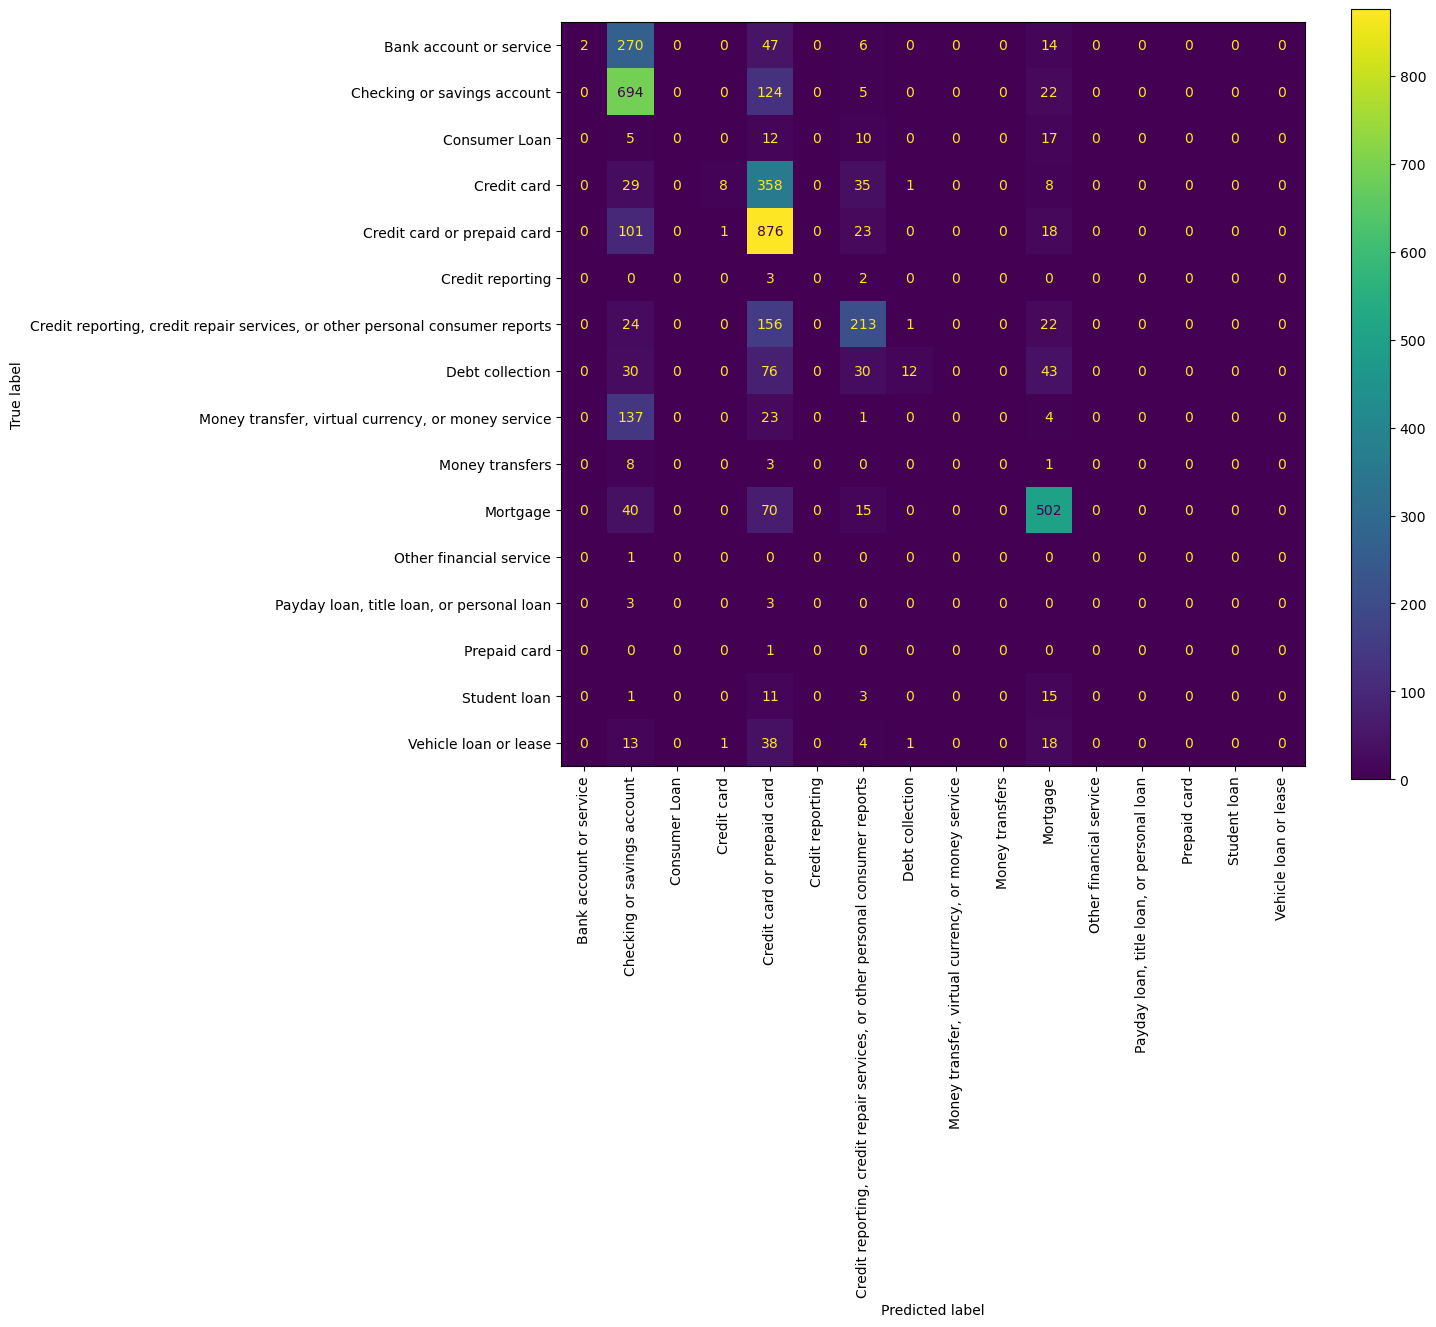

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = rf.predict(dX_test)

# Get the unique classes from the true labels
classes = np.unique(dy_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
# Create the matrix
cm = confusion_matrix(dy_test, y_pred, labels=classes)
cmp = ConfusionMatrixDisplay(cm, display_labels=classes)

cmp.plot(ax=ax)
plt.xticks(rotation='vertical')
plt.show()